<a href="https://colab.research.google.com/github/SanjibSarkarU/colab-NN/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 28 kB/s 
     |████████████████████████████████| 462 kB 64.6 MB/s 


In [1]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.models import Sequential
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('20220222_153859_hlc.csv', skiprows=1)
df = df.rename(columns={"Latitude (Deg N)": 'lat', "Longitude (Deg W)": 'lng'}, errors="raise")
df = df.loc[(df['lat'] != 0)]

In [ ]:
# df.dtypes

In [ ]:
#  df.lat.plot()

In [3]:
start = 10500
end = 13700
series_time = df.Time[start:end].to_numpy()
series_lat = df.lat[start:end].to_numpy()
series_lng = df.lng[start:end].to_numpy()
xaxis = np.array([i for i in range(len(series_lat))])

In [95]:
# type(series_lat)
xaxis.shape


(3200,)

In [ ]:
series_lat

In [4]:
def plot_dataset(xaxis, yaxis, xlabel= 'xaxis', ylabel= 'yaxis', color='r'):
  plt.plot(xaxis, yaxis, color=color)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [5]:
def train_test_split(dataset, percentage):
  train_size = int(len(dataset)*percentage)
  test_seze = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
plot_dataset(xaxis, series_lat)

In [ ]:
plot_dataset(xaxis, series_lng)

In [ ]:
plot_dataset(series_lng, series_lat)

In [7]:
# reshape
series_lat = np.reshape(series_lat,(len(series_lat),1))
series_lng = np.reshape(series_lng,(len(series_lng),1))
xaxis = np.reshape(xaxis,(len(xaxis),1))

In [101]:
# # Normalization is optional but recommended for neural network as certain 
# # activation functions are sensitive to magnitude of numbers. 
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer

In [114]:
# series_lat = scaler.fit_transform(series_lat)
# # series_lng = scaler.fit_transform(series_lng)

In [8]:
# split into train and test sets
train_lat, test_lat = train_test_split(series_lat, 0.7)
train_lng, test_lng = train_test_split(series_lng, 0.7)
train_xaxis, test_xaxis = train_test_split(xaxis, 0.7)
train_lat.shape

(2240, 1)

In [ ]:
train_lat

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator
def ts_data_preparation(features, window_size=5, future=1, batch_size =1, shuffle=False):
  target = features[(future-1):]
  features = features[:-(future-1)] if future != 1 else features   
  tensor = TimeseriesGenerator(features, target, length=window_size, batch_size=batch_size, shuffle=shuffle)
  return tensor


In [67]:
window_size=15
future =1
batch_size= 15
train_x_lat = ts_data_preparation(train_lat, window_size=window_size, future=future, batch_size=batch_size, shuffle=True)
train_x_lng = ts_data_preparation(train_lng, window_size=window_size, future=future, batch_size=batch_size, shuffle=True)

# test_lat = ts_data_preparation(test_lat, window_size=window_size, future=future, batch_size=batch_size, shuffle=False)


In [ ]:
train_x_lat[0]

In [223]:
len(train_x_lat)

560

In [68]:
#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

tf.keras.backend.clear_session()
def model_lstm(window_size):
  
  model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(50, activation='relu',return_sequences=True, input_shape=(window_size,1)),
                    tf.keras.layers.LSTM(50,activation='relu'),
                    tf.keras.layers.Dense(1)])
  model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
                loss='mse')
  model.summary()
  # print('Train...', model.summary())
  return model

In [69]:
model = model_lstm(window_size)
epochs = 50
model.fit(train_x_lat, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
149/149 [==============================] - 5s 19ms/step - loss: 34.9067
Epoch 2/50
149/149 [==============================] - 3s 19ms/step - loss: 9.3299e-07
Epoch 3/50
149/149 [==============================] - 3s 19ms/step - loss: 6.7908e-09
Epoch 4/50
149/149 [==============================] - 3s 19ms

In [ ]:
train_lat.shape

In [70]:
trainPredict_lat = model.predict(train_lat)

# trainPredict_lat = scaler.inverse_transform(trainPredict_lat)
# train_lat = scaler.inverse_transform(train_lat)

In [ ]:
trainPredict_lat

In [31]:
trainPredict_lat =np.array(trainPredict_lat)

In [71]:
testPredict_lat = model.predict(test_lat)

In [ ]:
test_lat

In [ ]:
plot_dataset(train_xaxis, trainPredict_lat, color ='b')
# plot_dataset(train_xaxis,train_lat)
# plot_dataset([i for i in range(len(series_lat))], series_lat)

In [ ]:
plot_dataset(train_xaxis,train_lat)

In [ ]:
plt.plot(test_lat, color ='r')

In [ ]:
testPredict_lat

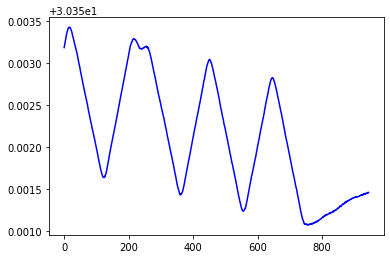

In [72]:
plt.plot(testPredict_lat, color='b')
# plt.plot(test_lat)

In [ ]:
plt.plot(series_lat)